# Processing Xiang 2021

Processing library-on-library data from [Xiang et al. 2021.](https://www.nature.com/articles/s41467-021-23576-0)

Library description:
In total, the 12K oligos target 3832 genes.
1. Select ~7000 genes from the drugable gene database (http://dgidb.org)
2. Discard all the exons which the DNA length is less than 23bp with filtering
3. Select the first three coding exons of each gene. If the exons number is less than 3, retain all the exons
4. Extract all the possible gRNA sequences (including the PAM sequence “NGG”) in the filtered exons sequence
5. Look up off-target sites of each gRNA with FlashFry (v 1.80)35 and discard gRNAs with potential off-target of 0–3bp
mismatches in human genome hg19 and rank each gRNA based on the number of off-target site in an ascending order
6. Map and extract the 10bp upstream and 4bp downstream flanking sequence of each selected gRNA, construct the
surrogate target sequence as 10bp upstream+23bp gRNA (include PAM)+4bp downstream=37bp
7. Filter out surrogate sites with BsmBI recognition site, because of GGA cloning
8. Compare all the selected gRNAs with the database of CRISPR-iSTOP36
9. Construct the full-length sequence of each synthetic oligo, which is 170bp

### Data Filters
1. pdna or etp > mean pdna -3 std

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt

import poola.core as pool

In [2]:
indel_frequencies = pd.read_csv('../data/raw/Xiang2021_S1_D10_NoDox.csv')
oligos = pd.read_csv('../data/raw/Xiang2021_microarray_oligos.csv')

First we extract context sequences from the oligo order file

In [3]:
first_oligo = oligos.loc[0, "sequences (5'to3')"]
first_context = 'GGAGCTGCAGCTGCAGGCAGCTCCCGGATC'
context_start = first_oligo.index(first_context)
print(context_start)
context_end = context_start + 30
assert first_oligo[context_start:context_end] == first_context

124


In [4]:
id_context = oligos.copy()
id_context['sgRNA Context Sequence'] = oligos["sequences (5'to3')"].str[context_start:context_end]
id_context = id_context[['Surrogate ID', 'sgRNA Context Sequence']]


We filter any sgRNA with lognormed reads less than 3 standard deviations from the mean

In [5]:
indel_frequencies_context = (indel_frequencies
                             .merge(id_context, how='inner',
                                    on='Surrogate ID'))
filtered_frequencies = (indel_frequencies_context[['gRNA', 'sgRNA Context Sequence',
                                                   'CleanReadsNumber', 'total_indel_eff',
                                                   'out_of_frame efficiency']]
                        .rename({'gRNA': 'sgRNA Sequence'}, axis=1))
filtered_frequencies['Lognormed_Reads'] = pool.lognorm(filtered_frequencies['CleanReadsNumber'])
filtered_frequencies = pool.filter_pdna(filtered_frequencies, ['Lognormed_Reads'], z_low=-3, z_high=None)
print('ETP filtered sgRNAs: ' + str(indel_frequencies_context.shape[0] - filtered_frequencies.shape[0]))


ETP filtered sgRNAs: 220


We see that indel frequencies are fairly uniformly distributed

<AxesSubplot:xlabel='total_indel_eff', ylabel='Count'>

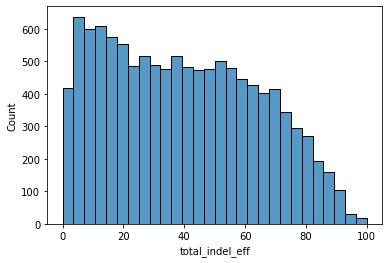

In [6]:
sns.histplot(filtered_frequencies['total_indel_eff'])

<AxesSubplot:xlabel='out_of_frame efficiency', ylabel='Count'>

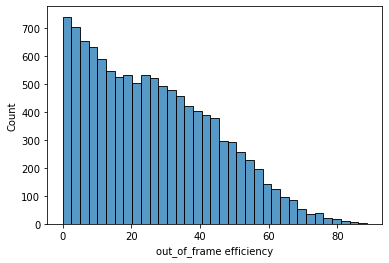

In [7]:
sns.histplot(filtered_frequencies['out_of_frame efficiency'])


The total indel efficacy has a higher Spearaman correlation than the out of frame
efficiency, so we'll use total indel efficacy as our measure of activity

In [8]:
sgrnas = filtered_frequencies['sgRNA Sequence'].unique()
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sgrnas)]])

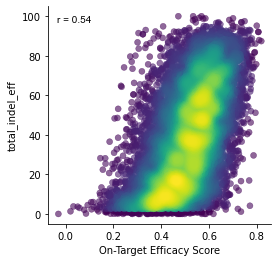

In [9]:
sgrna_designs = (filtered_frequencies.merge(design_df, how='inner',
                                            on='sgRNA Context Sequence'))
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sgrna_designs, x='On-Target Efficacy Score',
                         y='total_indel_eff')
gpplot.add_correlation(data=sgrna_designs, x='On-Target Efficacy Score',
                         y='total_indel_eff', method='spearman')
sns.despine()

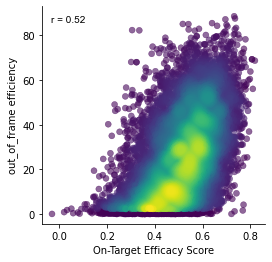

In [10]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sgrna_designs, x='On-Target Efficacy Score',
                         y='out_of_frame efficiency')
gpplot.add_correlation(data=sgrna_designs, x='On-Target Efficacy Score',
                         y='out_of_frame efficiency', method='spearman')
sns.despine()

In [13]:
out_df = filtered_frequencies[['sgRNA Sequence', 'sgRNA Context Sequence',
                               'total_indel_eff']].copy()
# some context sequences are lowercase for 
out_df['sgRNA Context Sequence'] = out_df['sgRNA Context Sequence'].str.upper()
out_df.shape

(11397, 3)

In [14]:
out_df.to_csv('../data/processed/Xiang2021_activity.csv', index=False)